### 可视化模型解释

In [12]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

def show_figures(train_dataset, xmin_xmax, model, scalered_current_input = None, figure_save_path = None):
    feature_list = train_dataset.features_list
    diameter_list = list(set(train_dataset.train_x[:, 7]))


    x_min, x_max = xmin_xmax[0], xmin_xmax[1]
    num_samples = 10000
    input = np.zeros((num_samples, 10))
    for i in range(10):
        if i == 7:
            input[:, i] = np.random.choice(diameter_list, num_samples)
        else:
            input[:, i] = np.linspace(x_min[i], x_max[i], num_samples)
    standard_scaler_inv_input = train_dataset.scaler.inverse_transform(input)
    scalered_input = torch.tensor(input).to(torch.float32).to(model.device)
    _, output_feat = model.model(scalered_input)
    output_feat = output_feat.cpu().detach().numpy()

    if scalered_current_input is not None:
        scalered_current_input = torch.tensor(scalered_current_input).to(torch.float32).to(model.device)
        _, output_feat_current = model.model(scalered_current_input)
        output_feat_current = output_feat_current.cpu().detach().numpy()
        standard_scaler_inv_current_input = train_dataset.scaler.inverse_transform(scalered_current_input.cpu().detach().numpy())

    # Set matplotlib style for better aesthetics
    # plt.style.use('seaborn-v0_8-poster')
    plt.style.use('ggplot')
    plt.rc('font', size=12)  # Adjust font size for readability
    
    fig, axs = plt.subplots(2, 5, figsize=(20, 8), dpi=300)  # Adjusted for better visual quality and size
    fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing to prevent label overlap

    coef = model.model.classifier.weight.cpu().detach().numpy()

    # Plot each feature map
    for i in range(2):
        for j in range(5):
            index = i * 5 + j
            # neg_flag = -1 if coef[0, index] < 0 else 1
            if index == 7:
                axs[i, j].scatter(standard_scaler_inv_input[:, index], output_feat[:, index] * coef[0, index], s=50)
            else:
                axs[i, j].plot(standard_scaler_inv_input[:, index], output_feat[:, index] * coef[0, index])
            
            if scalered_current_input is not None:
                current_x = standard_scaler_inv_current_input[0, index]
                current_y = output_feat_current[0, index] * coef[0, index]
                axs[i, j].scatter(current_x, current_y, color='blue', s=50)
                axs[i, j].axvline(x=current_x, color='blue', linestyle='--', linewidth=1)
                axs[i, j].axhline(y=current_y, color='blue', linestyle='--', linewidth=1)
                
                # Get axis limits
                xlim = axs[i, j].get_xlim()
                ylim = axs[i, j].get_ylim()
                
                # Calculate positions for text annotations
                x_text_position = current_x + (xlim[1] - xlim[0]) * 0.01  # Slightly right to the current x
                y_text_position = current_y + (ylim[1] - ylim[0]) * 0.01  # Slightly above the current y

                if i*5+j in [0, 1, 2, 5]:
                    aligement = 'right'
                else:
                    aligement = 'left'
                axs[i, j].text(current_x, ylim[0] + (ylim[1] - ylim[0]) * 0.02, 
                            f'{current_x:.2f}', fontsize=12, color='blue', horizontalalignment=aligement)
                # Display y value near the y-axis
                axs[i, j].text(xlim[0] + (xlim[1] - xlim[0]) * 0.01, current_y, 
                            f'{current_y:.2f}', fontsize=12, color='blue', horizontalalignment='left')

            # axs[i, j].set_title(fr'$\alpha_{{{i*5+j+1}}}$: {neg_flag * coef[0, i*5+j]:.2f}', fontsize=14)
            axs[i, j].set_xlabel(f'{feature_list[i*5+j]}', fontsize=12)  # Label x-axis
            axs[i, j].set_ylabel(fr'$\alpha_{{{j+1}}} f_{{{j+1}}}(x)$', fontsize=12)  # Label y-axis
            axs[i, j].tick_params(axis='both', which='major', labelsize=10)  # Adjust tick parameter font size
    plt.tight_layout()
    # plt.show()
    # plt.close()
    if figure_save_path is not None:
        plt.savefig(figure_save_path, bbox_inches='tight')
    # plt.close()

Predicted ROP: [[41.20095]], Real ROP: 42.12640800000001


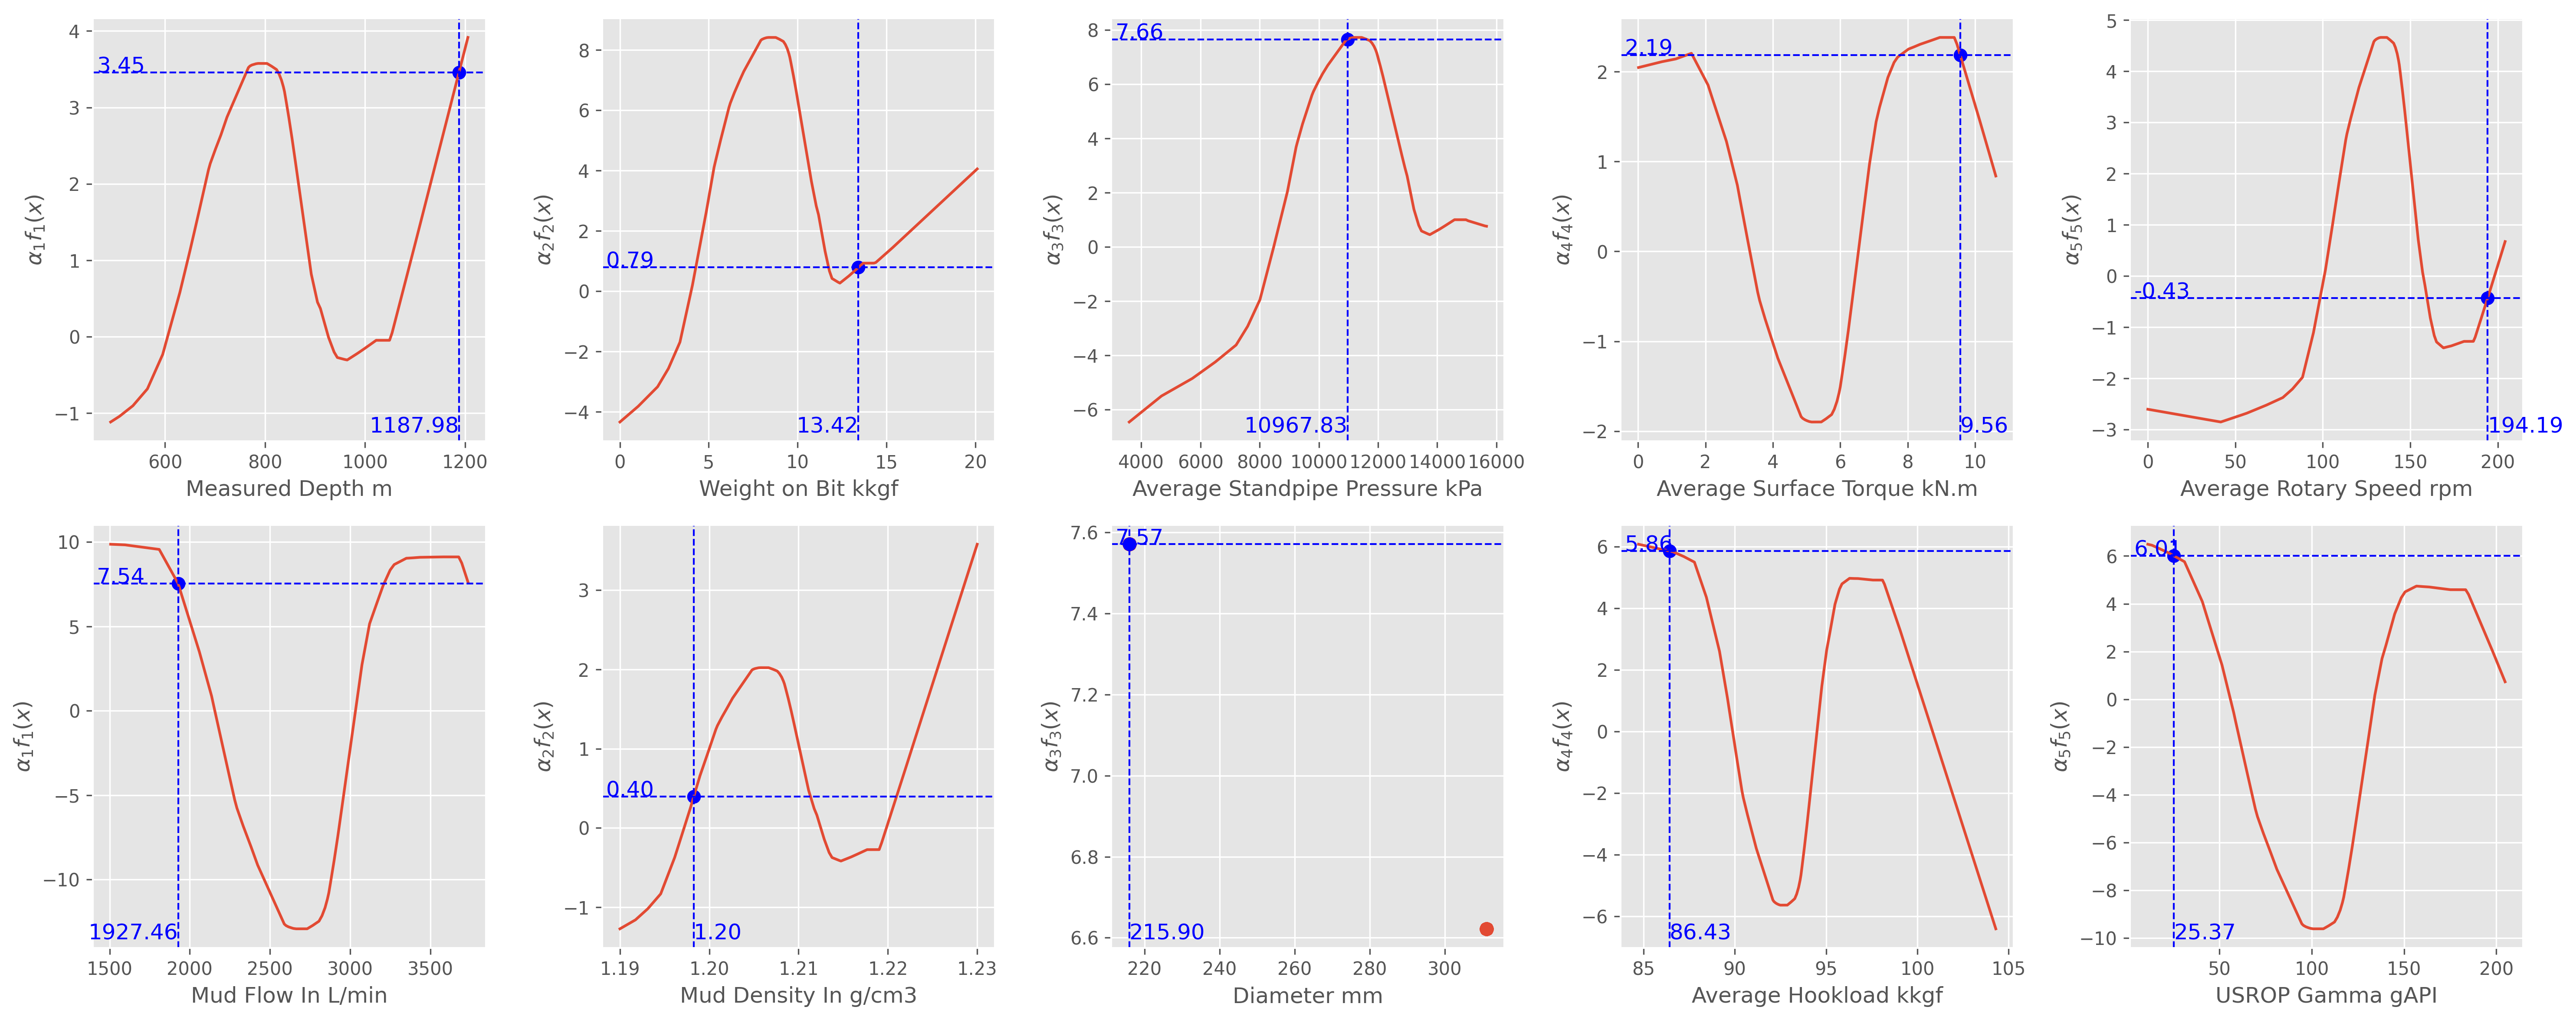

In [13]:
# 加载模型
import yaml
from models import BaseModel
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset import ROPContinousLearningDataset

device = torch.device('cpu')
config_path = './configs/rop_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

target_well = 'well_0'
model_saved_path =  f'./saved_model_New/Countinuouslearning/{target_well}/'

fold = 21
train_dataset = ROPContinousLearningDataset(target_well = target_well, train_val_test = 'train', rigind = fold)
test_dataset = ROPContinousLearningDataset(target_well = target_well, train_val_test = 'test', rigind = fold)

# concate test and train together
temp_train_x = np.concatenate([train_dataset.train_x, test_dataset.test_x], axis=0)
xmin_xmax = [temp_train_x.min(axis=0), temp_train_x.max(axis=0)]

test_sample_ind = 100
with torch.no_grad():
    best_model_path = os.path.join(model_saved_path, f'best_model_{fold}-v5.ckpt')
    model = BaseModel.load_from_checkpoint(best_model_path, **config['modelconfig']).to(device)
    model.eval()
    train_dataset = ROPContinousLearningDataset(target_well = 'well_0', train_val_test = 'train', rigind = fold)
    # scalered_current_input = np.random.randn(1, 10)
    scalered_current_input = test_dataset.test_x[test_sample_ind, :].reshape(1, -1)
    show_figures(train_dataset, xmin_xmax, model, scalered_current_input = scalered_current_input, figure_save_path = './FigureforRevision/InterpretablePredictions.pdf')
    # print predicted values and real values
    scalered_current_input = torch.tensor(scalered_current_input).to(torch.float32).to(device)
    pred, _= model.model(scalered_current_input)
    pred = pred.cpu().detach().numpy()
    print(f'Predicted ROP: {pred}, Real ROP: {test_dataset.test_y[test_sample_ind]}')